# Clustering High Dimensional Data

Team members:

\begin{itemize}
    \item Frick Bernhard (a01505541@unet.univie.ac.at)
    \item Postlmayr Billie Rosalie (a01307120@unet.univie.ac.at)
\end{itemize}

Former team members that opted out of the course:

\begin{itemize}
    \item Decsi István (a11834026@unet.univie.ac.at)
    \item Krivanek Yvonne-Nadine (a01404589@unet.univie.ac.at)
\end{itemize}

## Assignment

Implement one of the given algorithms and compare your results with the algorithms implemented in "Environment for DeveLoping KDD-Applications supported by Index-Structures" (ELKI) (see [Moodle](https://moodle.univie.ac.at/pluginfile.php/8780688/mod_resource/content/0/assignment1.pdf)).

## What we chose and why

We chose to implement the axis-parallel subspace clustering algorithm "subspace PREference weighted DEnsity CONnected clustering", PreDeCon for short, because it seems to be an interesting approach of combining different preexisting techniques that performs a lot better than other approaches when it comes to high dimensional data.

## How PreDeCon works

PreDeCon is an instance-based top-down approach, which means it starts out with the full dimensional dataset but choses to evaluate those on an instance based iteration. This kind of iteration puts a higher priority on some individually chosen dimensions.

Analogously to projected clustering which was introduced to enhance the quality of k-means like clustering algorithms in high-dimensional space, PreDeCon extends the well-founded notion of density connected clusters by incorporating subspace dimensionality preferences to ensure high quality results even in high-dimensional spaces.

PreDeCon does not use any sampling or approximation techniques, thus the result is determinate. It is also able to compute all subspace preference clusters of a certain dimensionality in a single scan over the database and is linear in the number of dimensions.

The paper where this algorithm is introduced and explained can be found here: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.68.5825&rep=rep1&type=pdf.

PreDeCon is configurable with five parameters:

\begin{itemize}
\item $\epsilon$ - The maximum distance that limits the epsilon-neighborhood of a point (real number)
\item $\mu$ - The minimum number of points in an epsilon neighborhood for a point to be considered a core point (natural number)
\item $\lambda$ - The maximum dimensionality of the searched clusters (natural number)
\item $\delta$ - The threshold for small eigenvalues (real number)
\item $\kappa$ - The penalty factor for deviations in preferred dimensions (real number)
\end{itemize}

## Pseudocode

Below is the concept of how our implementation works.

```python
PreDeCon:
for Point in Data[]:
    if Point is "unassigned" or "noise"
        get Npref[] and Pdim
        if CORE(Npref,Pdim):
            get unique ID
            while Npref[] is not empty:
                PointNpref = Npref.pop()
                get Reachable[] from PointNpref
                for PointReachable in Reachable[]:
                    if PointReachable is "unassigned":
                        add PointReachable to Npref[]
                    if PointReachable is "unassigned" or "noise":
                        PointReachable is ID
    else:
        Point is "noise"
```

## Implementation

The actual implementation can be found in `predecon.py`. The accompanying `script.py` file contains the code that applies our implentation to the iris test data set, plots the resulting clusters and calculates performance metrics.

In [1]:
from predecon import PreDeCon
from scipy.io import arff
import pandas as pd
import time
import numpy as np

In [2]:
fName = 'data/iris.arff'
tData, meta = arff.loadarff(fName)

In [3]:
D = pd.DataFrame(data=tData)
true_labels = D["class"]
D = D.drop("class", axis=1)

In [4]:
pdc = PreDeCon(e=2.5, m=2, l=2, d=0.05, k=100)
clustered_labels = pdc.fit(D)

In [5]:
unique_labels, unique_counts = np.unique(clustered_labels, return_counts=True)

Number of clusters:

In [6]:
len(unique_labels)

4

## Visualization

The relatively simple and small iris-dataset only has 150 data points with four features each. We decided to plot all six subspaces with a dimensionality of $l=2$ to be able to get some visual understanding of the performance of the clustering algorithm.

In [7]:
import itertools
import matplotlib.pyplot as plt

In [8]:
# Flatten the clustered labels (contains nested arrays with 1 element each)
clustered_labels = list(itertools.chain.from_iterable(clustered_labels))

# Assign a random color to each unique cluster id
color_map = dict(zip(unique_labels, np.random.rand(len(unique_labels), )))

# map clustered_labels to colors list
colors = list(map(color_map.get, clustered_labels))

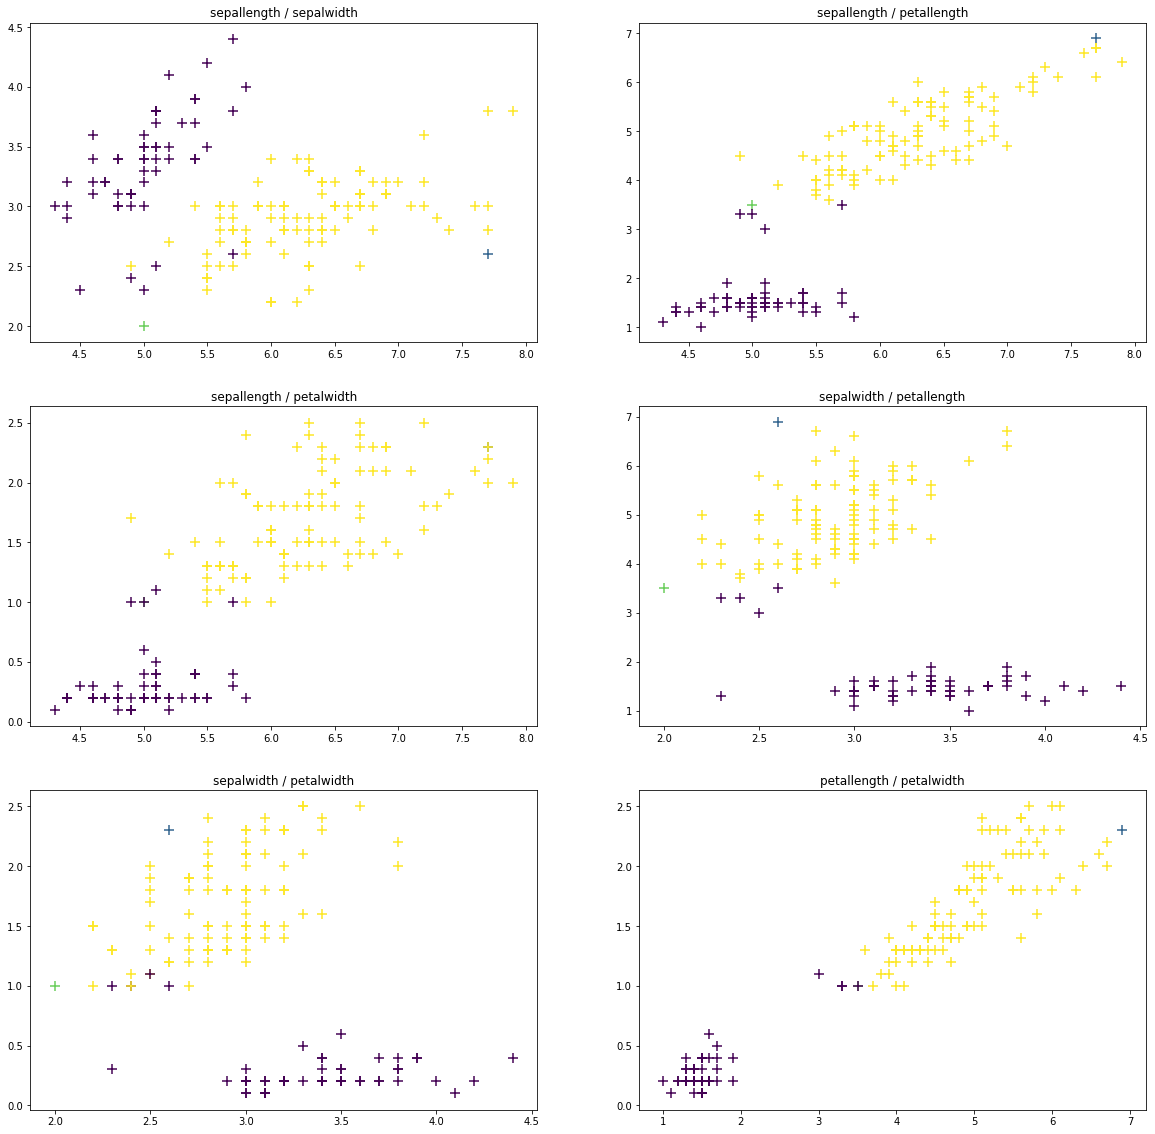

In [17]:
plt.rcParams["figure.figsize"] = (20,20)

names = meta.names()
names.remove("class")
plt_index = 1
for i, name in enumerate(names):
    for j in range(i+1, len(names)):
        x = D[names[i]]
        y = D[names[j]]
        plt.subplot(3, 2, plt_index)
        plt_index = plt_index + 1
        plt.scatter(x, y, s=100, c=colors, marker="+")
        plt.title(f"{names[i]} / {names[j]}")

plt.show()

## Evaluation

Since for the iris-dataset we used, the true labels are known, we are able to use performance evaluation methods that require knowledge of the ground truth.

We did not apply performance evaluation metrics that solely rely on the model itself and do not take into acccount that we have the true labels available.

To measure the performance of our implementation, we used the metrics that are provided by the python package `scikit-learn` (https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation).

Below follows an explanation and the results of all performance evaluation methods we applied.

In [10]:
from sklearn import metrics

### Adjusted Rand Index

https://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-index

The adjusted Rand index is a function that measures the similarity of the two assignments, ignoring permutations and with chance normalization.

Perfect labelling results in a score of 1.0, whereas a score of 0 denotes absolutely no correlation between the true and the predicted labels.

In [11]:
print("ARI:", metrics.adjusted_rand_score(true_labels, clustered_labels))

ARI: 0.5260487245058253


### Mutual Information (MI), Adjusted MI (AMI), Normalized MI (NMI)

https://scikit-learn.org/stable/modules/clustering.html#mutual-information-based-scores

The Mutual Information is a function that measures the agreement of the two assignments, ignoring permutations. Two different normalized versions of this measure are available, Normalized Mutual Information (NMI) and Adjusted Mutual Information (AMI). NMI is often used in the literature, while AMI was proposed more recently and is normalized against chance.

Both AMI and NMI are bounded above by 1, with a higher value indicating better results. MI on the other hand is not bounded.

In [12]:
print("AMI:", metrics.adjusted_mutual_info_score(true_labels, clustered_labels))
print("NMI:", metrics.normalized_mutual_info_score(true_labels, clustered_labels))
print("MI:", metrics.mutual_info_score(true_labels, clustered_labels))

AMI: 0.6149422748171449
NMI: 0.6240123786552145
MI: 0.5697488641022485


### Homogeneity, Completeness, V-Measure

https://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness-and-v-measure

Homogeneity: each cluster contains only members of a single class.

Completeness: all members of a given class are assigned to the same cluster.

Both homogeneity and completeness range from 0 to 1, with a higher value indicating better results. The harmonic mean of these two measures is called the V-Measure.

In [13]:
print("Homogeneity:", metrics.homogeneity_score(true_labels, clustered_labels))
print("Completeness:", metrics.completeness_score(true_labels, clustered_labels))
print("V-Measure:", metrics.v_measure_score(true_labels, clustered_labels))

Homogeneity: 0.5186077654319498
Completeness: 0.7831926343408337
V-Measure: 0.6240123786552146


## Fowlkes-Mallows Index

https://scikit-learn.org/stable/modules/clustering.html#fowlkes-mallows-scores

The Fowlkes-Mallows score FMI is defined as the geometric mean of the pairwise precision and recall:

$$
\text{FMI} = \frac{\text{True Positives}}{\sqrt{(\text{True Positives} + \text{False Positives}) \cdot (\text{True Positives} + \text{False Negatives})}}
$$

The score ranges from 0 to 1, with a higher value indicating better results.

In [14]:
print("FMI:", metrics.fowlkes_mallows_score(true_labels, clustered_labels))

FMI: 0.7356614739008676


## Evaluation Conclusion

Judging from the plots of our clustering results, we were able to achieve a relatively high accuracy. There were more clusters in our result than the classes which were given in the original data set. Small clusters could be easily merged with larger, neighboring clusters based on the unique character of the domain.

The following two runs on our hardware were both using the same iris data set and the following parameters:

$$
\epsilon=2.5 \qquad \mu=2 \qquad \lambda=1 \qquad \delta=0.05 \qquad \kappa=100
$$

### Performance on an Apple MacBook Pro 2015, Iris Dataset

Dual-Core 5th Gen Intel Core i5-5257U Processor - 2.7 / 3.1 GHz, 28W TDP

```
Runtime: 154.08 seconds
```

### Performance on a Razor Blade Stealth 2019, Iris Dataset

Quad-Core 10th Gen Intel Core i7-1065G7 Processor - 1.3 / 3.9 GHz, 25W TDP

```
Runtime: 107.75 seconds
```